# capacitated vehicle routing problem (CVRP)

## DHL collecting packages from branches

The Capacitated Vehicle Routing Problem (CVRP) is a well-known optimization problem in operations research and logistics. The problem involves determining the most efficient way to route a fleet of vehicles to deliver goods or services to a set of customers, subject to capacity and distance constraints.

In CVRP, a set of vehicles with limited capacities are available to serve a set of customers who have demands for goods or services. The objective is to find the optimal routes for the vehicles to minimize the total cost, which is usually a function of the distance traveled and the number of vehicles used.

The CVRP is a complex problem due to the large number of possible routes and the constraints involved. Some of the main constraints in CVRP include:

Vehicle capacity constraints: Each vehicle has a limited capacity that cannot be exceeded, so the total demand of the customers assigned to each vehicle cannot exceed its capacity.

Time window constraints: Each customer may have a specific time window during which they can receive the delivery or service, and the vehicles must arrive within these time windows.

Distance or travel time constraints: The vehicles have limited travel distances or times, which can be affected by factors such as traffic or road conditions.

This project pertains to the optimization of delivery routes for three Vans with 3 tons capacity and 2 lorries with 10 tons capacity of DHL in Rome. The objective is to identify the shortest path for the vehicles to collect cargos from the branches and deliver them to the Airport warehouse. The OpenStreetMap API is utilized to obtain accurate distance measurements between the relevant locations, and the CVRP algorithm, implemented through Google OR-Tools, is employed to determine the optimal route.

The demand for each branch is as below:

[0.5, 0.5, 1, 2, 1, 0.5, 2.5, 1.5, 0.3, 2, 0.2, 2.5, 1, 3, 2.5, 2, 1.8, 2, 0.7]

### Importing libraries

In [1]:
# Import the necessary libraries
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

### Defining the location 

In [2]:
# Define the city you are interested in
city = 'Rome, Roma, Lazio, Italy'

# Download the road network data for the city
graph = ox.graph_from_place(city, network_type='drive')

### Creating distance matrix by OpenStreetMap API

In [3]:
center_point = (41.95228752215774, 12.504880141395233)
point_1 = (41.91839197866251, 12.497052721160067)
point_2 = (41.90542173631579, 12.495491656596043)
point_3 = (41.91007987363588, 12.499004332137059)
point_4 = (41.903561610913364, 12.503747036316305)
point_5 = (41.89864479616125, 12.501884382537222)
point_6 = (41.89571149147544, 12.501217387863095)
point_7 = (41.890296335676034, 12.503059417775969)
point_8 = (41.89411183758527, 12.507462398517328)
Point_9 = (41.89483254575948, 12.506653897787684)
point_10 = (41.898795006676046, 12.515221927186413)
point_11 = (41.89068746708243, 12.526123523761367)
point_12 = (41.87578534158334, 12.524866274600512)
point_13 = (41.88729000986698, 12.536593027344281)
point_14 = (41.8982559983865, 12.53681278465086)
Point_15 = (41.89197603697094, 12.550829094751313)
point_16 = (41.908173661528195, 12.545035462434145)
Point_17 = (41.8867977416723, 12.543450896159467)
point_18 = (41.88724053196941, 12.536580728033972)
point_19 = (41.908120091325564, 12.519379118976484)

points = [center_point, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8,
          Point_9, point_10, point_11, point_12, point_13, point_14, Point_15, point_16, Point_17,
          point_18, point_19]

# Get the nodes corresponding to the points
nodes = []
for point in points:
    node = ox.distance.nearest_nodes(graph, point[1], point[0])
    nodes.append(node)

# Calculate the distance matrix between the nodes
distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if i == j:
            distance_matrix[i, j] = 0
        elif nx.has_path(graph, nodes[i], nodes[j]):
            distance_matrix[i, j] = nx.shortest_path_length(
                graph, nodes[i], nodes[j], weight='length')
            distance_matrix[j, i] = distance_matrix[i, j]

### Plotting

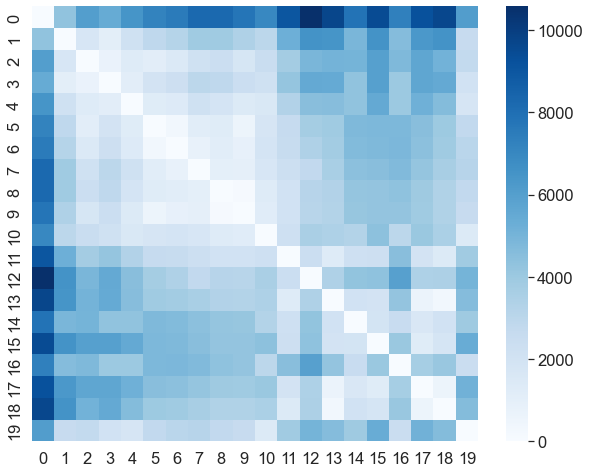

In [4]:
# plotting the heatmap of distance matrix
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))

sns.heatmap(distance_matrix, cmap="Blues")
plt.show()

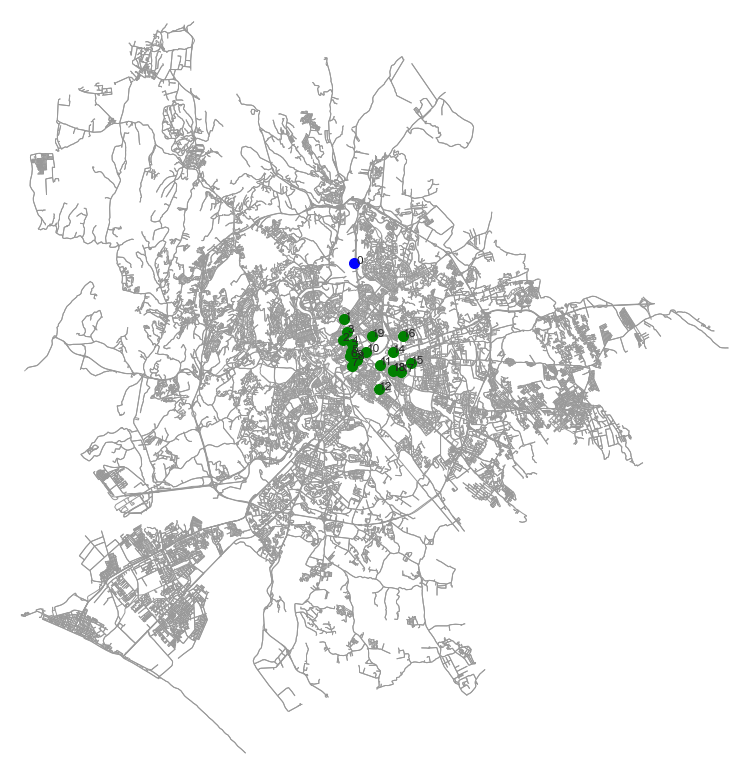

In [5]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=100, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)


ax.axis('off')
plt.show()

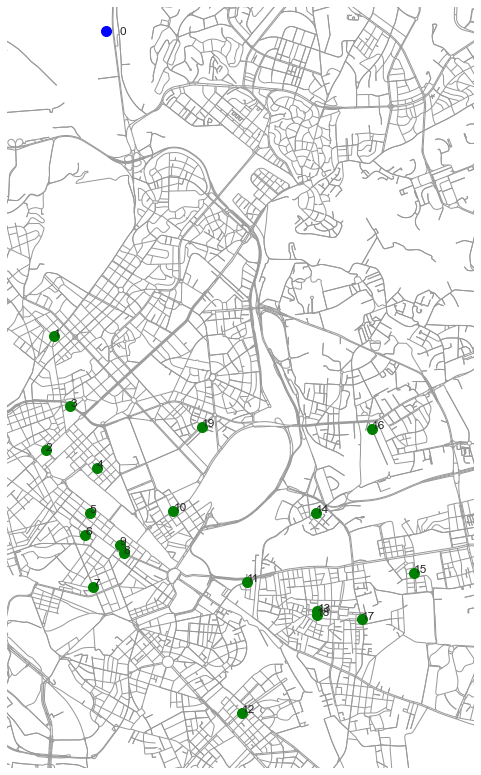

In [6]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=100, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)

ax.set_xlim(12.49, 12.56)
ax.set_ylim(41.87, 41.955)

ax.axis('off')
plt.show()

### Create the data

For this problem, 3 Vans ( capacity = 3.5 ton) and 2 Lorries ( capacity = 10 ton) are used.\
The weight of cargo for each branch is as below (order by the number of brach):\
[0, 0.5, 1.5, 1, 2, 3, 0.5, 2.5, 1.5, 0.3, 2, 0.2, 2.5, 1, 3, 2.5, 2, 1.8, 2, 0.7] (ton)

In [7]:
ds = np.round(distance_matrix)

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = ds
    data['num_vehicles'] = 5
    data['depot'] = 0
    data['demands'] = [0, 0.5, 0.5, 1, 2, 1, 0.5, 2.5, 1.5, 0.3, 2, 0.2, 2.5, 1, 3, 2.5, 2, 1.8, 2, 0.7]
    data['vehicle_capacities'] = [3, 3, 3, 10, 10]
    return data

In [9]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

### Create the distance callback 

In [10]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]


transit_callback_index = routing.RegisterTransitCallback(distance_callback)

### Add the demand callback and capacity constraints

In [11]:
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(
    demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

True

### Set the cost of travel

In [12]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [13]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    400000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

### Set search parameters (PATH_CHEAPEST_ARC)

Here I choose the PATH_CHEAPEST_ARC, however you can try the other methods that are defined in: https://developers.google.com/optimization/routing/routing_options#first_solution_strategy

In [14]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

### Add the solution printer

In [15]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

In [16]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

Objective: 2209540
Route for vehicle 0:
 0 Load(0) ->  15 Load(2.5) ->  0 Load(2.5)
Distance of the route: 18988m
Load of the route: 2.5

Route for vehicle 1:
 0 Load(0) ->  16 Load(2) ->  19 Load(2.7) ->  0 Load(2.7)
Distance of the route: 15870m
Load of the route: 2.7

Route for vehicle 2:
 0 Load(0) ->  12 Load(2.5) ->  0 Load(2.5)
Distance of the route: 21150m
Load of the route: 2.5

Route for vehicle 3:
 0 Load(0) ->  3 Load(1) ->  4 Load(3) ->  9 Load(3.3) ->  8 Load(4.8) ->  7 Load(7.3) ->  6 Load(7.8) ->  5 Load(8.8) ->  2 Load(9.3) ->  1 Load(9.8) ->  0 Load(9.8)
Distance of the route: 17519m
Load of the route: 9.8

Route for vehicle 4:
 0 Load(0) ->  14 Load(3) ->  17 Load(4.8) ->  18 Load(6.8) ->  13 Load(7.8) ->  11 Load(8.0) ->  10 Load(10.0) ->  0 Load(10.0)
Distance of the route: 21013m
Load of the route: 10.0

Total distance of all routes: 94540m
Total load of all routes: 27.5


In [17]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

In [18]:
routes = get_routes(solution, routing, manager)
# Display the routes.
for i, route in enumerate(routes):
    print('Route', i+1, route)

Route 1 [0, 15, 0]
Route 2 [0, 16, 19, 0]
Route 3 [0, 12, 0]
Route 4 [0, 3, 4, 9, 8, 7, 6, 5, 2, 1, 0]
Route 5 [0, 14, 17, 18, 13, 11, 10, 0]


C:\Users\fadak\AppData\Local\Temp/ipykernel_9272/4259388908.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(route)-1)  # Create a colormap with the same length as the number of segments


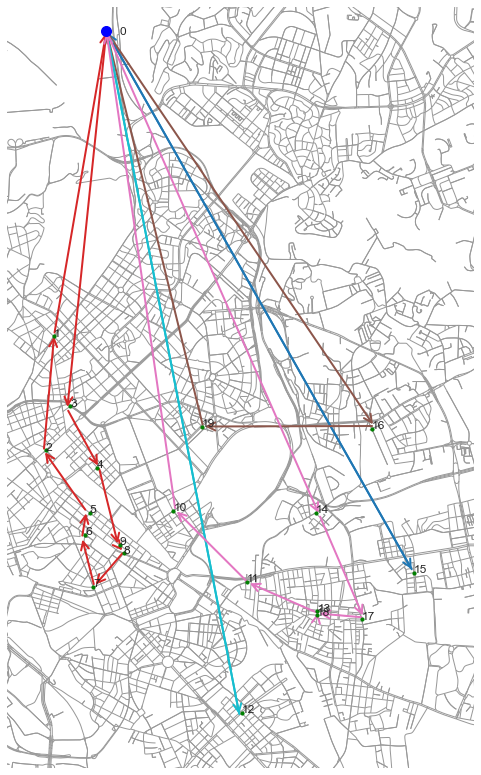

In [19]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=10, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)
    
# Define the order of the nodes to connect
for j, route in enumerate(routes):
    cmap = cm.get_cmap('tab10', len(route)-1)  # Create a colormap with the same length as the number of segments
    color = cmap(j)  # Get the color for the current segment
    # Plot the lines between the nodes in the specified order
    for i in range(len(route) - 1):
        arrow = FancyArrowPatch((points[route[i]][1], points[route[i]][0]), (points[route[i+1]][1], points[route[i+1]][0]),
                                arrowstyle='->', color=color , linewidth=2, mutation_scale=20)
        ax.add_patch(arrow)    
        
# Set the limits of the x-axis and y-axis to zoom in on a specific part of the plot
ax.set_xlim(12.49, 12.56)
ax.set_ylim(41.87, 41.955)

ax.axis('off')
plt.show()